# Importing Packages

In [1]:
# filter warnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# keras imports
import tensorflow as tf


from tensorflow.keras import preprocessing, callbacks 
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten

# import seaborn as sns
# import tsfel
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, sys, logging, h5py
from PIL import Image
from pathlib import Path as Pathlb


# Custom imports
from scipy import signal
import seaborn as sns


sns.set()

sys.path.insert(0, os.path.abspath(os.path.join('..')))
from MLPackage import Features as feat
from MLPackage import config as cfg


os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Setting Logger

In [2]:
project_dir = os.getcwd()[:-5]
log_path = os.path.join(project_dir, 'logs')
temp_dir = os.path.join(project_dir, "temp")

Pathlb(log_path).mkdir(parents=True, exist_ok=True)



def create_logger(level):
    loggerName = "2DCNN_ipynb"
    Pathlb(log_path).mkdir(parents=True, exist_ok=True)
    grey = '\x1b[38;21m'
    blue = '\x1b[38;5;39m'
    yellow = '\x1b[38;5;226m'
    red = '\x1b[38;5;196m'
    bold_red = '\x1b[31;1m'
    reset = '\x1b[0m'

    logger = logging.getLogger(loggerName)
    logger.setLevel(level)
    formatter_colored = logging.Formatter(blue + '[%(asctime)s]-' + yellow + '[%(name)s @%(lineno)d]' + reset + blue + '-[%(levelname)s]' + reset + bold_red + '\t\t%(message)s' + reset, datefmt='%m/%d/%Y %I:%M:%S %p ')
    formatter = logging.Formatter('[%(asctime)s]-[%(name)s @%(lineno)d]-[%(levelname)s]\t\t%(message)s', datefmt='%m/%d/%Y %I:%M:%S %p ')
    file_handler = logging.FileHandler( os.path.join(log_path, loggerName + '_loger.log'), mode = 'w')
    file_handler.setLevel(level)
    file_handler.setFormatter(formatter)
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.INFO)

    stream_handler.setFormatter(formatter_colored)

    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    return logger
logger = create_logger(logging.DEBUG)


logger.info("Importing libraries....")

[12/07/2021 12:01:11 PM ]-[2DCNN_ipynb @37]-[INFO]		Importing libraries....


# Image Preprocessing and Loading

## Loading Images

[12/08/2021 01:57:53 PM ]-[2DCNN_ipynb @1]-[INFO]		[INFO] reading dataset....
[12/08/2021 02:00:38 PM ]-[2DCNN_ipynb @9]-[INFO]		barefoots.shape: (1745, 80, 60, 200)
[12/08/2021 02:00:38 PM ]-[2DCNN_ipynb @10]-[INFO]		metadata.shape: (1745, 10)


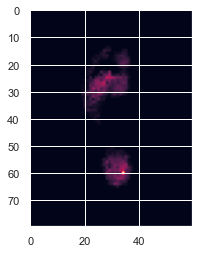

In [91]:
logger.info("[INFO] reading dataset....")
with h5py.File('c:\\Project\\Worksheet\\Datasets\\footpressures_align.h5', "r") as hdf: #todo cfg.configs["paths"]["stepscan_dataset"]
    barefoots = hdf.get("/barefoot/data")[:]
    metadata = hdf.get("/barefoot/metadata")[:]


data = barefoots.transpose(0,2,3,1)

logger.info(f"barefoots.shape: {data.shape}")
logger.info(f"metadata.shape: {metadata.shape}")
plt.imshow(data[1,:,:,:].sum(axis=2))


In [ ]:
np.max(data[1,:,:,:])

## Extracting Image Features

In [9]:
features = list()
labels = list()

for label, sample in zip(metadata, data):
    # print(np.shape(sample))
    # print(np.max(sample))
    try:
        B = sample.sum(axis=1).sum(axis=0)
        A = np.trim_zeros(sample.sum(axis=1).sum(axis=0))
        aa = np.where(B == A[0])
        bb = np.where(B == A[-1])
        # print(aa[0][0])
        # print(bb[0][0])
        # print(np.trim_zeros(sample.sum(axis=1).sum(axis=0)))

        if aa[0][0]<bb[0][0]:
            features.append(feat.prefeatures(sample[10:70, 10:50, aa[0][0]:bb[0][0]]))
            labels.append(label)
        else:
            print(aa[0][0],bb[0][0])
            k=sample
            l=label
    except:
        continue
    # labels.append(label)
    # break
    # f = np.trim_zeros(sample.sum(axis=1).sum(axis=0),'f').shape[0]
    # b = np.trim_zeros(sample.sum(axis=1).sum(axis=0),'b').shape[0]
    # print(b, f,)

    # temp = np.zeros(sample[:,:,b:f].shape)
    # temp[sample[:,:,b:f] > 5] = 1
    # CD = np.sum(temp, axis=2)

    
        
    # # plt.imshow(sample[:,:,100])
    # print(np.max(sample[:,:,100]))
    # # break
    


logger.info(f"len prefeatures: {len(features)}")
logger.info(f"prefeatures.shape: {features[0].shape}")
logger.info(f"labels.shape: {labels[0].shape}")

np.save(os.path.join(temp_dir, 'prefeatures-SS.npy'), features)
np.save(os.path.join(temp_dir, 'metadata.npy'), labels)

# plt.imshow(CD)

0 0


[12/07/2021 01:20:26 PM ]-[2DCNN_ipynb @43]-[INFO]		len prefeatures: 1743
[12/07/2021 01:20:26 PM ]-[2DCNN_ipynb @44]-[INFO]		prefeatures.shape: (60, 40, 10)
[12/07/2021 01:20:26 PM ]-[2DCNN_ipynb @45]-[INFO]		labels.shape: (10,)


## Loading Image features

In [10]:
Loading_path = os.path.join(temp_dir, 'prefeatures-SS.npy')
prefeatures = np.load(Loading_path)
logger.info("prefeature shape: {}".format(prefeatures.shape))

Loading_path = os.path.join(temp_dir, 'metadata.npy')
metadata = np.load(Loading_path)
logger.info("prefeature shape: {}".format(metadata.shape))

# #CD, PTI, Tmax, Tmin, P50, P60, P70, P80, P90, P100
logger.info("batch_size: {}".format(cfg.configs["CNN"]["batch_size"]))

[12/07/2021 01:20:29 PM ]-[2DCNN_ipynb @3]-[INFO]		prefeature shape: (1743, 60, 40, 10)
[12/07/2021 01:20:29 PM ]-[2DCNN_ipynb @7]-[INFO]		prefeature shape: (1743, 10)
[12/07/2021 01:20:29 PM ]-[2DCNN_ipynb @10]-[INFO]		batch_size: 32


## flatenning Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0012436092
(1, 60, 40)


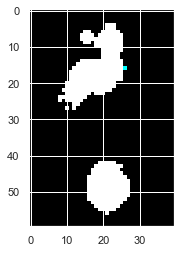

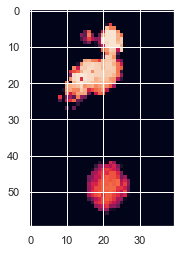

In [77]:

input1 = tf.keras.layers.Input(shape=(60, 40, 3), dtype = tf.float64, name="original_img")
x = tf.cast(input1, tf.float32)
output = tf.keras.layers.Rescaling(1./36185)(x)
model1 = tf.keras.models.Model(inputs=input1, outputs=output, name=cfg.configs['CNN']['base_model'])




# plt.imshow(images[1,:,:,:])
# plt.figure()
# plt.imshow(y_pred[0,...])

images  = list()
for sample in prefeatures:
    # sample = sample.transpose((2, 0, 1))

    # total_image = sample[0,:,:]
    # total_image1 = sample[5,:,:]

    # for i in range(1,5):
    #     total_image = np.concatenate((total_image, sample[i,:,:]), axis=1)
    #     total_image1 = np.concatenate((total_image1, sample[i+5,:,:]), axis=1)




    # total_image = np.concatenate((total_image, total_image1), axis=0)
    # total_image = total_image[:,:, np.newaxis]
    # total_image = np.concatenate((total_image, total_image, total_image), axis=2)

    # images.append(total_image)


    t_image = sample[:, :, 0:3]
    y_pred = model1.predict(t_image[np.newaxis,:,:,0])
    images.append(t_image)
    # print(np.max(images[1:2,:,:,:]))
    print(np.max(y_pred))
    print(np.shape(y_pred))


    # plt.figure(figsize=(20,20))
    # plt.imshow( total_image)
    # plt.show()

    # print(type(total_image))
    # print(total_image.dtype)
    # print(total_image.shape)



    # print(result)

    break
images =np.array(images)
plt.imshow(images[0,...])
plt.figure()
plt.imshow(y_pred[0,...])

In [30]:
# CC=tf.keras.utils.to_categorical( metadata[:,0], num_classes=len(np.unique(metadata[:,0])))
# # one_hot_labels==CC
# len(np.unique(metadata[:,0]))
from sklearn import preprocessing as pre
indices = metadata[:,0]
le = pre.LabelEncoder()
le.fit(indices)
le.classes_
indices=le.transform(indices)
len(np.unique(indices))

depth = len(np.unique(metadata[:,0]))
one_hot_labels = tf.one_hot(indices, depth)

one_hot_labels


<tf.Tensor: shape=(80,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=cfg.configs["CNN"]["image_size"]))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(2, activation='softmax'))
#model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adadelta(), metrics=['accuracy'])
weight_path="{}_weights.best.hdf5".format('casia-D_classification-smax')
    
checkpoint = callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = False)
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_cv, y_cv),callbacks = [checkpoint],shuffle=True)
#model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
model1=load_model('/home/pk/Desktop/pradeep/Saeed/code/casia-D_classification-smax_weights.best.hdf5')
score_cv = model1.evaluate(x_cv, y_cv, verbose=0)
score_te = model1.evaluate(x_test, y_test, verbose=0)
for os in range(51,98):#opens set
    path='/home/pk/Desktop/pradeep/Saeed/Archive/'+str(os)+'_subject.0/'
    temp = load_data(path);temp=np.vstack(temp);X_os.append(temp)
X_os=np.vstack(X_os); X_os = X_os.reshape(X_os.shape[0], img_rows, img_cols, 1);X_os = X_os.astype('float32');  X_os /= 255
y_os=np.append(np.expand_dims(np.ones(len(X_os)),1),np.expand_dims(np.zeros(len(X_os)),1),1)
score_os = model1.evaluate(X_os, y_os, verbose=0)
#pred=model1.predict(X_os)
U_matrix.append([u,score_cv[1],score_te[1],score_os[1]])
K.clear_session()
#    print('Test loss:', score[0])
#    print('Test accuracy:', score[1])
np.savetxt('Casia=D_results_softmax.csv',np.vstack(U_matrix),delimiter=',')

# Making Base Model

In [48]:
try:
    logger.info(f"Loading { cfg.configs['CNN']['base_model'] } model...")
    base_model = eval("tf.keras.applications." + cfg.configs["CNN"]["base_model"] + "(weights=cfg.configs['CNN']['weights'], include_top=cfg.configs['CNN']['include_top'])")
    logger.info("Successfully loaded base model and model...")

except Exception as e: 
    
    base_model = None
    logger.error("The base model could NOT be loaded correctly!!!")
    print(e)


base_model.trainable = False

CNN_name = cfg.configs["CNN"]["base_model"].split(".")[0]

input = tf.keras.layers.Input(shape=cfg.configs["CNN"]["image_size"], dtype = tf.float64, name="original_img")
x = tf.cast(input, tf.float32)
x = tf.keras.layers.Rescaling(1./36185)(x)
x = eval("tf.keras.applications." + CNN_name + ".preprocess_input(x)")
x = base_model(x)
x = tf.keras.layers.GlobalMaxPool2D()(x)
x = tf.keras.layers.Dense(256, activation='relu', name="last_dense")(x)
output = tf.keras.layers.Dense(cfg.configs['CNN']['class_numbers'], activation='softmax', name="prediction")(x) # cfg.configs['CNN']['class_numbers']

[12/07/2021 03:19:58 PM ]-[2DCNN_ipynb @2]-[INFO]		Loading mobilenet.MobileNet model...


[12/07/2021 03:19:59 PM ]-[2DCNN_ipynb @4]-[INFO]		Successfully loaded base model and model...


# The CNN Model

In [49]:
model = tf.keras.models.Model(inputs=input, outputs=output, name=cfg.configs['CNN']['base_model'])

# Freeze the layers 
for layer in model.layers[-2:]:
    layer.trainable = True

for i,layer in enumerate(model.layers):
    print(i,layer.name,layer.trainable)

model.summary() 


tf.keras.utils.plot_model(model, to_file=cfg.configs['CNN']['base_model'] + ".png", show_shapes=True)
plt.show()


0 original_img True
1 tf.cast_1 True
2 rescaling True
3 tf.math.truediv_1 True
4 tf.math.subtract_1 True
5 mobilenet_1.00_224 False
6 global_max_pooling2d_1 True
7 last_dense True
8 prediction True
Model: "mobilenet.MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 120, 200, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 120, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 120, 200, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 120, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 120, 200, 

In [58]:
print(images[1:2,:,:,:].shape)
print(one_hot_labels.shape)
np.max(images[...,1])

(1, 120, 200, 3)
(1743, 80)


36185.0

In [50]:
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(), 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['accuracy']
    )
time = int(timeit.timeit())*1_000_000
checkpoint = [
        callbacks.ModelCheckpoint(cfg.configs["CNN"]["saving_path"], save_best_only=True, monitor="val_loss"),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
        callbacks.EarlyStopping( monitor="val_loss", patience=50, verbose=1),
        callbacks.TensorBoard(log_dir='TensorBoard_logs/{time}')  
    ]    


history = model.fit(
    images,
    one_hot_labels,
    batch_size=cfg.configs["CNN"]["batch_size"],
    callbacks=[checkpoint],
    epochs= cfg.configs["CNN"]["epochs"],
    validation_split=cfg.configs["CNN"]["validation_split"],
    verbose=cfg.configs["CNN"]["verbose"],
    shuffle=True,
)

Epoch 1/10
44/44 [==============================] - 25s 520ms/step - loss: 4.8097 - accuracy: 0.0143 - val_loss: 4.8289 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 20s 457ms/step - loss: 4.7975 - accuracy: 0.0143 - val_loss: 4.8283 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 20s 456ms/step - loss: 4.7857 - accuracy: 0.0143 - val_loss: 4.8282 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 20s 445ms/step - loss: 4.7742 - accuracy: 0.0143 - val_loss: 4.8286 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 18s 415ms/step - loss: 4.7631 - accuracy: 0.0143 - val_loss: 4.8294 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/10
44/44 [==============================] - 18s 421ms/step - loss: 4.7523 - accuracy: 0.0143 - val_loss: 4.8307 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/10
44/44 [======================

Text(0, 0.5, 'Accuracy')

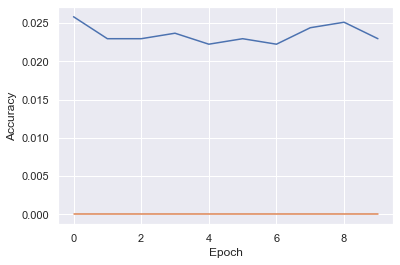

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')